In [3]:
# Imports 
import os
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Reading Data

Create data structure for each peice of audio.
- Audio file
- Annotation file
- annotated beats
- tracked beats
- evaluation?

### Single file loading

In [186]:
# data/BallroomData/Quickstep/Albums-Ballroom_Classics4-20.wav
# data/BallroomData/Tango/Media-105508.wav - Easy
# data/BallroomData/ChaChaCha/Albums-Cafe_Paradiso-08.wav
# data/BallroomData/Rumba-American/Albums-GloriaEstefan_MiTierra-04.wav
# data/BallroomData/Waltz/Albums-Ballroom_Classics4-01.wav - Very hard

# get file
file_path = 'data/BallroomData/ChaChaCha/Albums-Cafe_Paradiso-08.wav'

# resample rate - based on method of ellis 2007
resample_rate = 8000

# load audio
y, sr = librosa.load(file_path, sr=resample_rate)



# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative value set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide - I havent done this
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

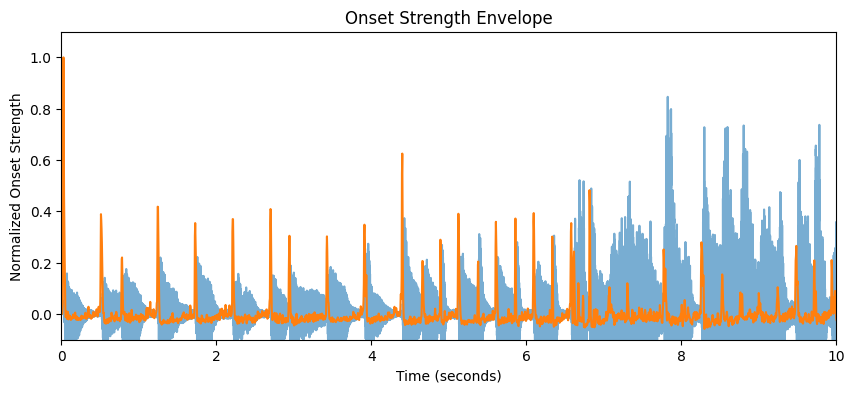

In [211]:
from scipy.signal import butter, filtfilt, lfilter

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    """Apply a high-pass filter to the signal."""
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004, show=True):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa remove DC like this - How do they do this in lab solution?
    onset_strength = lfilter([1.0, -1.0], [1.0, -0.99], onset_strength, axis=-1)
    
    #  normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    if(show): plot_onset_envelope_strength(y, onset_strength_norm, hop_sec)
        
    return onset_strength_norm

def plot_onset_envelope_strength(y, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    
    # normalise range 0 - 1
    onset_strength = onset_strength / np.max(onset_strength)
    
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.ylim([-0.1, 1.1])
    plt.show()

hop_sec=0.004
odf = onset_strength_envelope(y, sr, hop_sec=hop_sec)




# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

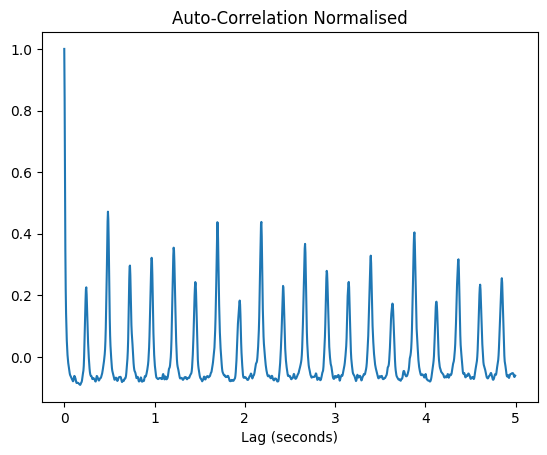

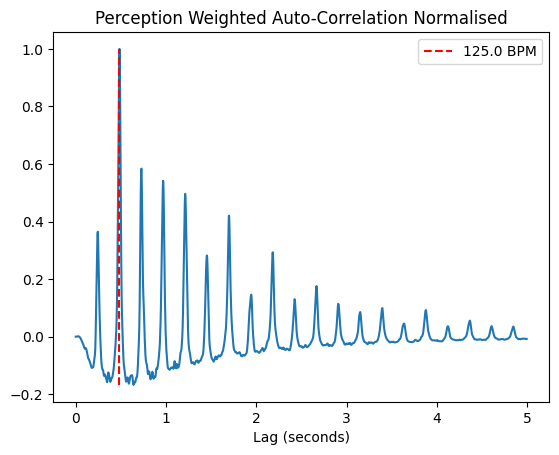

In [215]:
# Apply perceptual weighting based on tempo tapping data
def perceptual_weighting(t, t0=0.5, sigma_t=1.4): # t0 (bpm) and sigma_t (octaves) values from ellis 2007  
    # avoid div by zero error 
    epsilon = 1e-10
    t = np.maximum(t, epsilon)
    
    log_2_t_over_t0 = np.log2(t / t0)
    
    W_t = np.exp(-0.5 * (log_2_t_over_t0 / sigma_t) ** 2)
    
    return W_t

def plot_auto_c(auto_c, tps, largest_frame, bpm, sr, hop_length):
    auto_c = auto_c / np.max(auto_c)
    tps = tps / np.max(tps)
    
    times = np.arange(len(auto_c)) * (hop_length / sr)

    plt.plot(times, auto_c)
    plt.title('Auto-Correlation Normalised')
    plt.xlabel('Lag (seconds)')
    plt.show()

    plt.plot(times, tps)
    plt.vlines(largest_frame * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='r', linestyle='--', label='{} BPM'.format(bpm))
    plt.legend()
    plt.title('Perception Weighted Auto-Correlation Normalised')
    plt.xlabel('Lag (seconds)')
    plt.show()
    
def tempo_estimate(odf, sr, hop_sec, max_lag_s=5, show=True):
    hop_length = int(hop_sec * sr)

    # only correlate reasonable tempo range - 5 seconds = 12 BPM is plenty
    max_size = max_lag_s * sr / hop_length

    # write my own ? 
    auto_c = librosa.autocorrelate(odf, max_size=max_size)

    # weighting function needs lag in seconds
    lags_seconds = np.arange(len(auto_c)) * (hop_length / sr)

    # apply perceptual weightinig get tempo period strengths
    tps = auto_c * perceptual_weighting(lags_seconds) 
        
    # find largest correlation frame
    largest_frame = np.argmax(tps[1:])
    
    # calculate bpm
    bpm = 60 * sr / (largest_frame * hop_length)
    
    # calculate secondadry bpm
    # two further functions are calculated by resampling T P S to one-half and one-third, 
    # respectively, of its original length, adding this to the original T P S, 
    # then choosing the largest peak across both these
    
    if(show): plot_auto_c(auto_c, tps, largest_frame, bpm, sr, hop_length)
    
    return bpm

bpm_estimate = tempo_estimate(odf, sr, hop_sec)

# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

# Librosa

Text(0.5, 1.0, 'Beat tracking - BPM: 85.22727272727273')

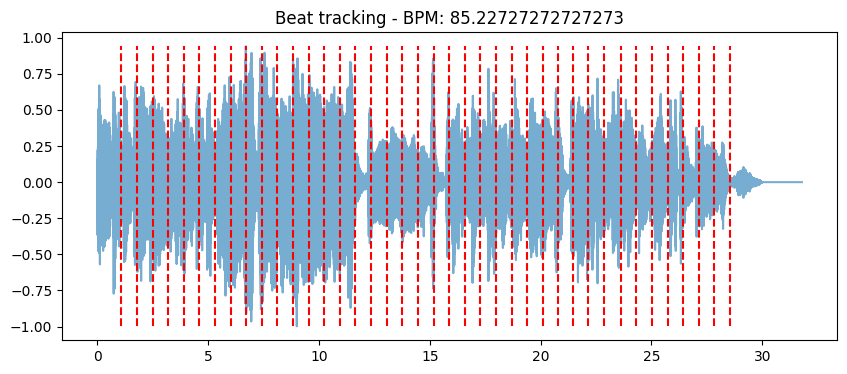

In [20]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beats, sr=sr) # to get times from indexes

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
plt.vlines(beat_times, ymin=min(y), ymax=max(y), color='r', linestyle='--', label='Onsets')  # Plot beats
plt.title('Beat tracking - BPM: {}'.format(tempo))

